In [1]:
import torch 
import numpy as np
from matplotlib import pyplot as plt
import time

from solver import Solver
from dataset import SytheticData
from model import marmousi, box_smooth

In [2]:
from utils_plot import plot_model, plot_section

In [3]:
# Device 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'device={device}')

device=cuda


In [4]:
# Mesh Configurations
h = 0.015
dt = 0.001
nx = 200
nz = 100
nt = 1600
f0 = 10
t0 = 1/f0

cfl = 4 * dt / h
npw = 4 / f0 / h
print('CFL number is about' + f' {cfl:.2f}')
print('Number of grid points per wave length is about' + f' {npw:.1f}')

CFL number is about 0.27
Number of grid points per wave length is about 26.7


In [5]:
# Training configurations
num_epochs = 120
batch_size = 16
# batch_size = 8
learning_rate = 0.01
shuffle = True

In [6]:
# Sources and receivers
sx = np.arange(1, nx, 2)
sources_xz = np.c_[np.ones_like(sx), sx]
rx = np.arange(1, nx)
receivers_xz = np.c_[2*np.ones_like(rx), rx]

In [7]:
# True model
path_wavespeed = '/root/autodl-nas/geodata/marmousi/marmousi_vel.segy'
wavespeed = marmousi(nz, nx, path_wavespeed)
wavespeed /= 1000

Text(0.5, 1.0, 'wavespeed in Marmousi')

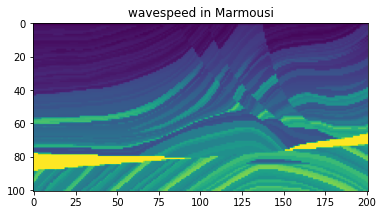

In [8]:
plt.imshow(wavespeed, aspect='equal')
plt.title(r'wavespeed in Marmousi')

In [9]:
print('wavespeed in ({:.2f}, {:.2f})'.format(wavespeed.min(), wavespeed.max()))

wavespeed in (1.50, 5.50)


In [10]:
wavespeed_true = torch.from_numpy(wavespeed).to(torch.float32)

In [11]:
# Dataset and dataloader
dataset = SytheticData(wavespeed_true, h, dt, nt, t0, f0, sources_xz, receivers_xz)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [12]:
# Initial model
wavespeed_initial = box_smooth(wavespeed_true, 40, 40).to(device)
wavespeed_initial_numpy = wavespeed_initial.clone().cpu().numpy()
wavespeed_initial.requires_grad = True

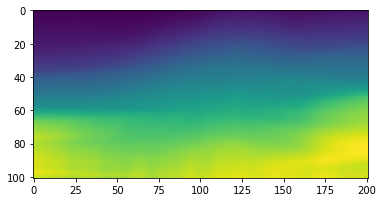

In [13]:
plt.imshow(wavespeed_initial_numpy)

In [14]:
# Initial solver
solver_initial = Solver(wavespeed_initial, h, dt, nt, t0, f0, receivers_xz)

In [15]:
# Loss function
criterion = torch.nn.MSELoss()

In [16]:
# Optimizer 
all_params = [wavespeed_initial]
optimizer = torch.optim.Adam(all_params, lr=learning_rate)
# optimizer = torch.optim.RMSprop(all_params, lr=learning_rate)
# optimizer = torch.optim.NAdam(all_params, lr=learning_rate)
# optimizer = torch.optim.Adamax(all_params, lr=learning_rate)
# optimizer = torch.optim.Adadelta(all_params, lr=learning_rate)
# optimizer = torch.optim.Adagrad(all_params, lr=learning_rate)

In [17]:
# Logger 
loss_list = []
loss_t_list = []
def  seis_t(v):
    v_t = (v[:, :, 1:] - v[:, :, :-1]) / dt
    return v_t

In [18]:
# Training
time_begin_train = time.time()
n_batch = 0
for n_epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        n_batch += 1
        time_begin = time.time()
        sx, obs = data 
        optimizer.zero_grad()
        syn = solver_initial.step(sx)
        syn_t = seis_t(syn)
        obs_t = seis_t(obs)
        loss_val = criterion(syn, obs.to(device))
        loss_t_val = criterion(syn_t, obs_t.to(device))
        loss_total_val = loss_val + 0.01*loss_t_val
        loss_total_val.backward()
        loss_list.append(loss_val.item())
        loss_t_list.append(loss_val.item())
        optimizer.step()
        time_end = time.time()
        print(f"Epoch {n_epoch+1}, Batch {n_batch}, loss_total={loss_total_val:.6f}, loss={loss_val:.6f}, loss_t={loss_t_val:.6f}, time={time_end - time_begin:.2f}s")
time_end_train = time.time()
print(f'Total cost time {time_end_train - time_begin_train:.2f}s')

Epoch 1, Batch 1, loss_total=8.750844, loss=0.188706, loss_t=856.213745, time=19.33s
Epoch 1, Batch 2, loss_total=8.746960, loss=0.189716, loss_t=855.724426, time=21.79s
Epoch 1, Batch 3, loss_total=8.001267, loss=0.169881, loss_t=783.138672, time=23.09s
Epoch 1, Batch 4, loss_total=6.610915, loss=0.142193, loss_t=646.872314, time=22.79s
Epoch 1, Batch 5, loss_total=5.956398, loss=0.129212, loss_t=582.718689, time=22.72s
Epoch 1, Batch 6, loss_total=6.441635, loss=0.136771, loss_t=630.486389, time=23.93s
Epoch 1, Batch 7, loss_total=5.951736, loss=0.121505, loss_t=583.023132, time=24.68s
Epoch 2, Batch 8, loss_total=5.283654, loss=0.110144, loss_t=517.351013, time=23.24s
Epoch 2, Batch 9, loss_total=4.101978, loss=0.084989, loss_t=401.698944, time=25.78s
Epoch 2, Batch 10, loss_total=4.255355, loss=0.089398, loss_t=416.595734, time=24.09s
Epoch 2, Batch 11, loss_total=3.646000, loss=0.075841, loss_t=357.015900, time=24.22s
Epoch 2, Batch 12, loss_total=3.646350, loss=0.075731, loss_t=3

In [19]:
wavespeed_inversion = wavespeed_initial.detach().cpu().numpy()

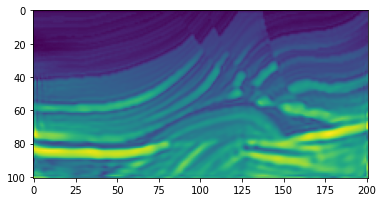

In [20]:
plt.imshow(wavespeed_inversion)

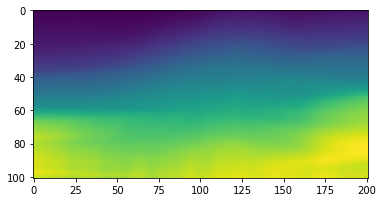

In [21]:
plt.imshow(wavespeed_initial_numpy)

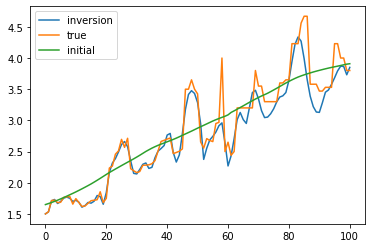

In [22]:
ncol = 100
plt.plot(wavespeed_inversion[:, ncol], label='inversion')
plt.plot(wavespeed_true[:, ncol], label='true')
plt.plot(wavespeed_initial_numpy[:, ncol], label='initial')
plt.legend()

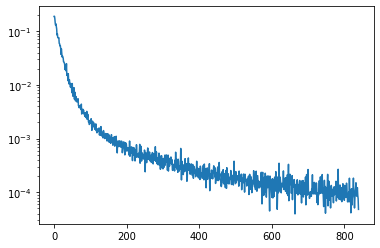

In [23]:
plt.plot(loss_list)
plt.yscale('log')

In [25]:
path = './data/marmousi_/'#!!!
np.save(path+'wavespeed_true', wavespeed)
np.save(path+'wavespeed_initial', wavespeed_initial_numpy)
np.save(path+'wavespeed_inversion', wavespeed_inversion)
np.save(path+'loss', np.array(loss_list))
np.save(path+'loss_t', np.array(loss_t_list))